<a href="https://colab.research.google.com/github/Andysimps0n/DL_lecture/blob/main/MNIST_with_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [13]:
def prepare_gpu_loader(dataset, batch_size, shuffle=False):
  x = torch.stack([data for data, _ in dataset]).to(device)
  y = torch.tensor([target for _, target in dataset]).to(device)

  gpu_dataset = TensorDataset(x, y)
  return DataLoader(gpu_dataset, batch_size=batch_size, shuffle=shuffle)


batch_size = 128
train_loader = prepare_gpu_loader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = prepare_gpu_loader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = prepare_gpu_loader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class MLPModel(nn.Module):
  def __init__(self):
    super(MLPModel, self).__init__()
    self.linear1 = nn.Linear(784, 128)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(128, 10)

  def forward(self, x):
    x = x.view(-1, 784)

    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)

    return x



In [15]:
loss_function = nn.CrossEntropyLoss()

In [22]:


sample_data, _ = next(iter(val_loader))
print(sample_data.device)


cpu
cpu
cuda:0


In [25]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

model = MLPModel()
model.to(device)

learning_rate = 0.005
optimizer = optim.Adam(model.parameters())

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 30
for i in range(epoch):
  train_loss = 0
  model.train()

  for input_X, true_y in train_loader:
    optimizer.zero_grad()
    input_X, true_y = input_X.to(device), true_y.to(device)

    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X)
    loss = loss_function(pred_y.squeeze(), true_y)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f"epoch {i+1} / {epoch} done")

  train_loss /= len(train_loader) #배치당 평균 손실
  list_train_loss.append(train_loss)
  list_epoch.append(i)

  model.eval()
  val_loss = 0


  #validation 세트에서도 오차 계산해서 오버피팅 검사
  with torch.no_grad():
      for input_X, true_y in val_loader:
          input_X = input_X.squeeze()
          input_X = input_X.view(-1, 784)
          pred_y = model(input_X)

          loss = loss_function(pred_y.squeeze(), true_y)
          val_loss += loss.item()
      val_loss = val_loss / len(val_loader)
      list_val_loss.append(val_loss)


  model.eval()
  correct = 0
  with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        acc = correct.item() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)

  print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))



epoch 1 / 30 done
Epoch: 0, Train Loss: 0.3251557142838188, Val Loss: 0.19322499689422076, Test Acc: 95.03%
epoch 2 / 30 done
Epoch: 1, Train Loss: 0.14597355582944269, Val Loss: 0.13831199394373955, Test Acc: 96.48%
epoch 3 / 30 done
Epoch: 2, Train Loss: 0.1010566610137901, Val Loss: 0.11610221975966345, Test Acc: 96.98%
epoch 4 / 30 done
Epoch: 3, Train Loss: 0.07610945729419703, Val Loss: 0.10316437737473959, Test Acc: 97.44%
epoch 5 / 30 done
Epoch: 4, Train Loss: 0.059525823523111816, Val Loss: 0.09102909571102148, Test Acc: 97.48%
epoch 6 / 30 done
Epoch: 5, Train Loss: 0.047296995561465126, Val Loss: 0.09749671549217988, Test Acc: 97.5%
epoch 7 / 30 done
Epoch: 6, Train Loss: 0.03742211205584695, Val Loss: 0.09028802715430531, Test Acc: 97.71%
epoch 8 / 30 done
Epoch: 7, Train Loss: 0.02916022355827834, Val Loss: 0.09239063995501286, Test Acc: 97.41%
epoch 9 / 30 done
Epoch: 8, Train Loss: 0.023685948365865767, Val Loss: 0.08493163488522361, Test Acc: 97.61%
epoch 10 / 30 done


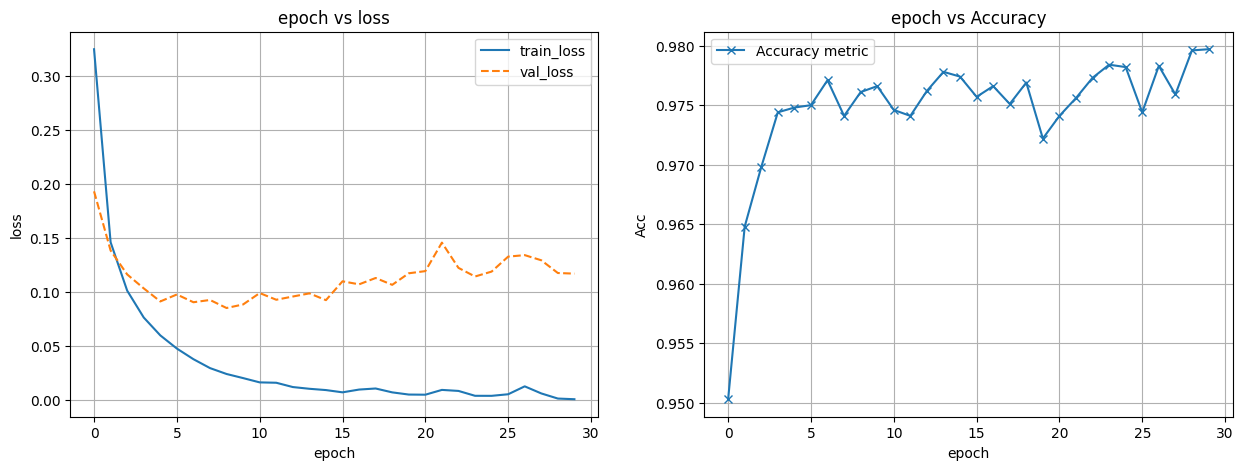

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()